# HU 3: Exploratory Data Analysis (EDA)

**Project:** Sales Analysis with Python & Power BI  
**User Story:** HU 3  
**Objective:** Perform exploratory analysis to understand sales behavior, identify trends, and generate visual insights.

### Tasks Covered
1. [x] Connect to PostgreSQL (`clean_sales`).
2. [x] Feature Engineering (Extract Year/Month).
3. [x] Calculate Descriptive Metrics (Mean, Median, Std Dev).
4. [x] **Visualization 1:** Monthly Sales Trend (Seasonality).
5. [x] **Visualization 2:** Top 5 Best-Selling Products (Pareto).
6. [x] **Visualization 3:** Sales Distribution by Client Type (Boxplot).
7. [x] Document insights.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from database.db_connection import get_db_engine

# Visual configuration for professional charts
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [2]:
engine = get_db_engine()
table_name = 'clean_sales'

if engine:
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, engine)
        
        # Ensure Date is datetime (sometimes read_sql reads as object depending on driver)
        df['Date'] = pd.to_datetime(df['Date'])
        
        print(f"Successfully loaded {len(df)} rows for analysis.")
    except Exception as e:
        print(f"Error loading data: {e}")
else:
    print("Failed to connect to DB.")

Successfully created engine for database: hu_db
Successfully loaded 1228936 rows for analysis.


In [8]:
# Create temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.strftime('%B') # Full month name (January, February...)
print(df['Year'].unique())

# Preview
df[['Date', 'Year', 'Month', 'Month_Name', 'Total_Sales']].head()


[2025]


,Date,Year,Month,Month_Name,Total_Sales
0,2025-11-17,2025,11,November,3406.0
1,2025-11-09,2025,11,November,28124.0
2,2025-10-28,2025,10,October,2979.0
3,2025-11-14,2025,11,November,7396.0
4,2025-10-21,2025,10,October,7131.0


## 1. Descriptive Statistics

We calculate the core statistical metrics to understand the central tendency and dispersion of the sales data. 
- **Target Variable:** `Total_Sales`
- **Key Metrics:** Mean (Average Ticket), Median (Typical Sale), and Standard Deviation (Volatility).

--- Global Sales Metrics ---
Total Revenue:   $21,913,466,050.00
Average Ticket:  $17,831.25 (Mean)
Median Sale:     $15,424.00 (Typical Sale)
Volatility:      $23,583.36 (Std Dev)


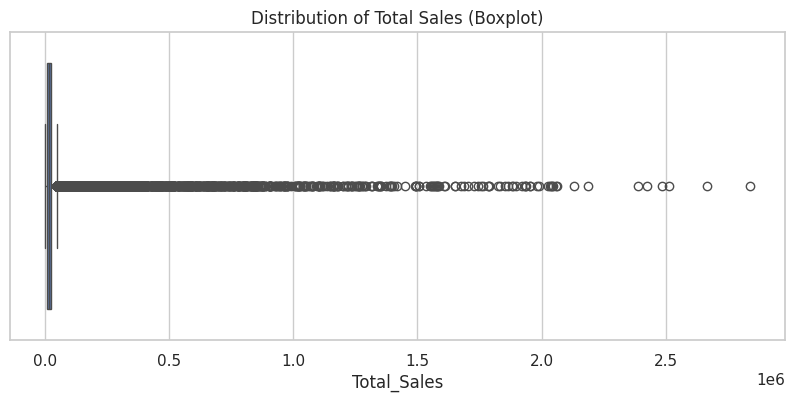

In [6]:
# Calculate key metrics for Total_Sales
mean_sales = df['Total_Sales'].mean()
median_sales = df['Total_Sales'].median()
std_sales = df['Total_Sales'].std()
total_revenue = df['Total_Sales'].sum()

print(f"--- Global Sales Metrics ---")
print(f"Total Revenue:   ${total_revenue:,.2f}")
print(f"Average Ticket:  ${mean_sales:,.2f} (Mean)")
print(f"Median Sale:     ${median_sales:,.2f} (Typical Sale)")
print(f"Volatility:      ${std_sales:,.2f} (Std Dev)")

# Quick Distribution check
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Total_Sales'])
plt.title('Distribution of Total Sales (Boxplot)')
plt.show()

## 2. Visual Analysis

We generate strategic visualizations to answer specific business questions regarding trends, top performers, and customer behavior.

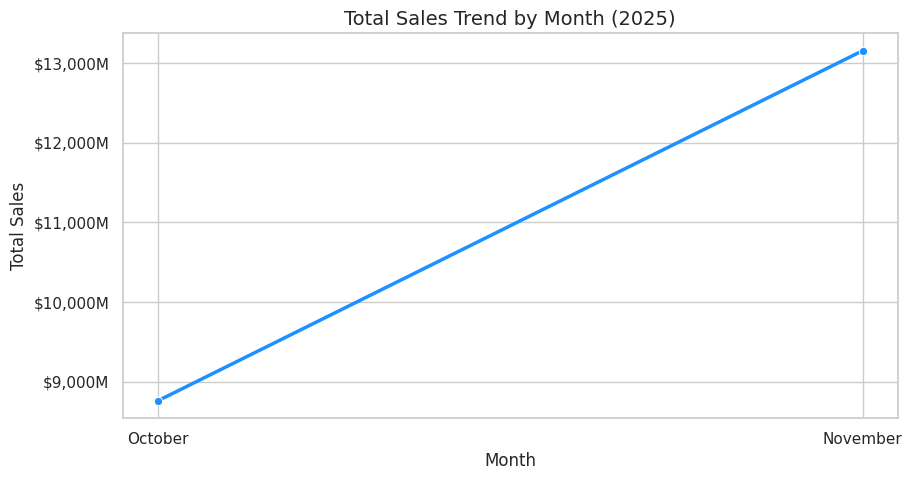

In [ ]:
from matplotlib.ticker import FuncFormatter

# Helper to format millions
def millions_formatter(x, pos):
    return f'${x/1e6:,.0f}M'

# Group data
monthly_sales = df.groupby(['Month', 'Month_Name'])['Total_Sales'].sum().reset_index().sort_values('Month')

plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=monthly_sales, x='Month_Name', y='Total_Sales', marker='o', linewidth=2.5, color='dodgerblue')

# Apply formatter to Y axis 
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.title('Total Sales Trend by Month (2025)', fontsize=14)
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.show()

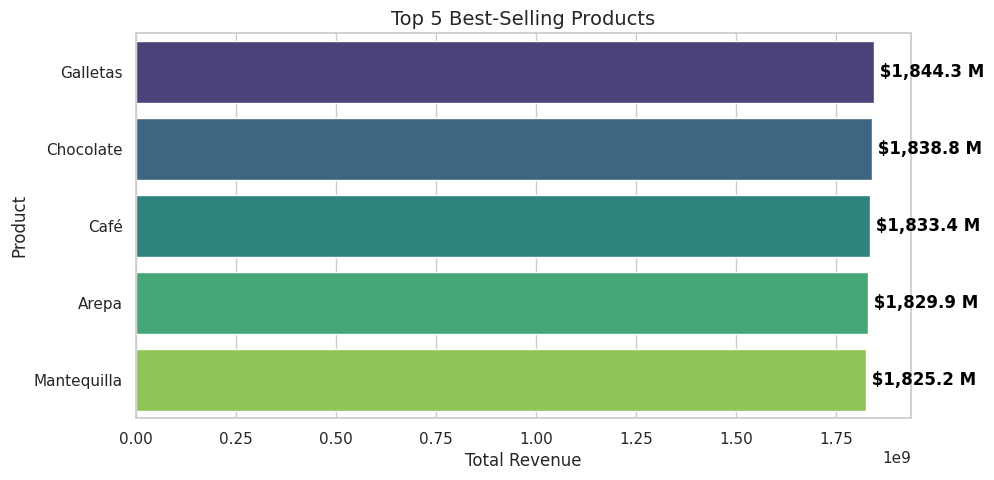

In [15]:
# Group by Product
top_products = df.groupby('Product')['Total_Sales'].sum().reset_index()

# Sort descending and take top 5
top_products = top_products.sort_values('Total_Sales', ascending=False).head(5)

# Plot
plt.figure(figsize=(10, 5))
barplot = sns.barplot(data=top_products, x='Total_Sales', y='Product', hue='Product', palette='viridis', legend=False)

# Add labels inside bars
for i, v in enumerate(top_products['Total_Sales']):
    barplot.text(v, i, f" ${v/1e6:,.1f} M", color='black', va='center', fontweight='bold')

plt.title('Top 5 Best-Selling Products', fontsize=14)
plt.xlabel('Total Revenue')
plt.show()

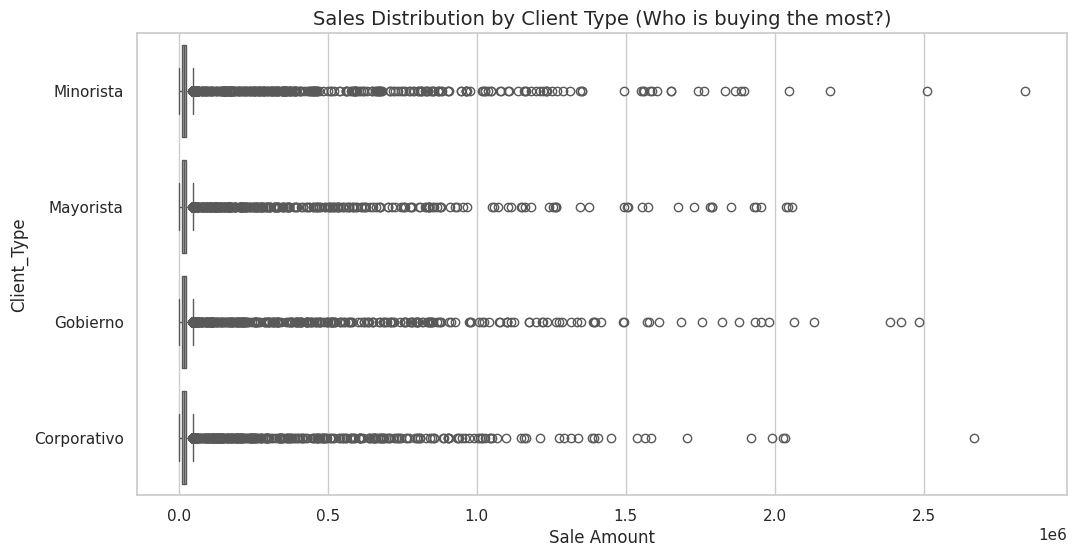

In [16]:
plt.figure(figsize=(12, 6))
# Boxplot split by Client Type to see who generates the outliers
sns.boxplot(data=df, x='Total_Sales', y='Client_Type', hue='Client_Type', palette='Set2', legend=False)

plt.title('Sales Distribution by Client Type (Who is buying the most?)', fontsize=14)
plt.xlabel('Sale Amount')
plt.show()

## 3. Key Insights & Conclusions

Based on the statistical analysis and visualizations, we identified the following patterns:

1.  **High Market Volatility:** 
    The Standard Deviation (**$23k**) is significantly higher than the Mean (**$17k**). This indicates that sales are highly volatile, driven by massive high-value outliers rather than a consistent average ticket.

2.  **Strong Growth Trend:** 
    We observed a sharp **~47% increase** in revenue from October to November 2025 (rising from ~$8.8B to ~$13.0B). This suggests strong seasonality or the impact of end-of-year campaigns.

3.  **Balanced Product Portfolio:** 
    The Top 5 best-selling products (Galletas, Chocolate, Café, Arepa, Mantequilla) show a very even distribution, each generating approximately **$1.8 Billion**. There is no single dominant product; the catalog performs uniformly well.

4.  **Uniform Customer Behavior:** 
    Contrary to typical market segmentation, all `Client_Types` (Government, Minorista, Mayorista, Corporativo) exhibit surprisingly similar spending patterns: a relatively low median sale price but with extreme outliers reaching up to **$3M**. This suggests that "Client Type" might not be the primary differentiator for sale size in this dataset.